In [1]:
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import json
import seaborn as sns
import re

pp = pprint.PrettyPrinter(indent=4)

In [ ]:
remove_negative_gaze = False

filter_blacklist = True
blacklist = ['a']

df = pd.read_csv('data/experiment_results_public_lab.csv')

if filter_blacklist:
    df = df[~df.workerid.isin(blacklist)]

# reindex the df
df.reset_index(drop=True, inplace=True)

def parse(data):
    while data[0] != '{':
        data = data[1:]
    while data[-1] != '}':
        data = data[:-1]
    data = data.replace('\\', '')
    data = re.sub(
        r'(?<=strategy":")(.*)(?="\})',
        lambda m: m.group(0).replace('"', '\\"'),
        data,
        count=1)
    json_data = {}
    try:
        json_data = json.loads(data)
    except:
        pp.pprint(data[-200:])
    return json_data

df = pd.concat([df, pd.json_normalize(df.apply(lambda x: parse(x['answer']), axis=1, ), max_level=0)], axis=1)

if remove_negative_gaze:
    df.gaze = df.gaze.apply(lambda x: {key:val for key, val in json.loads(base64.b64decode(x)).items() if int(key) > 0})
else:
    df.gaze = df.gaze.apply(lambda x: json.loads(base64.b64decode(x)))
df.sort_values(by=['workerid', 'userTrialId', 'timestamp'], inplace=True)
df.reset_index(drop=True, inplace=True)


df

,filename,listnumber,assignmentid,hitid,workerid,origin,timestamp,partid,questionid,answer,...,calibrationPrecision,answerTime,choicePos,choice,coordinates,gaze,correct,techDiffs,otherComments,strategy
0,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,Laura,PROLIFIC,16-Jan-2025 11:07:25,7104,106383,"""{\""sent_msg\"":\""re\"",\""objs\"":[\""sq_re\"",\""ci...",...,"[86, 76, 85]",26763,0,sq_re,"{'sent_msg': {'x': 826, 'y': 118, 'width': 100...","{'42': {'x': 197, 'y': 285, 'eyes': {'left': {...",1,"The calibration part, I think I accidentally s...",NaN,NaN
1,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,Laura,PROLIFIC,16-Jan-2025 11:07:25,7104,106391,"""{\""sent_msg\"":\""ci\"",\""objs\"":[\""tr_re\"",\""ci...",...,NaN,4969,1,ci_gr,"{'sent_msg': {'x': 826, 'y': 118, 'width': 100...","{'16': {'x': 755, 'y': 297, 'eyes': {'left': {...",1,NaN,NaN,NaN
2,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,Laura,PROLIFIC,16-Jan-2025 11:07:25,7104,106394,"""{\""sent_msg\"":\""ci\"",\""objs\"":[\""tr_gr\"",\""ci...",...,NaN,2449,1,ci_re,"{'sent_msg': {'x': 826, 'y': 118, 'width': 100...","{'-2538': {'x': 731, 'y': 292, 'eyes': {'left'...",1,NaN,NaN,NaN
3,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,Laura,PROLIFIC,16-Jan-2025 11:07:25,7104,106392,"""{\""sent_msg\"":\""gr\"",\""objs\"":[\""sq_re\"",\""ci...",...,NaN,3821,2,sq_gr,"{'sent_msg': {'x': 826, 'y': 118, 'width': 100...","{'15': {'x': 785, 'y': 270, 'eyes': {'left': {...",1,NaN,NaN,NaN
4,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,Laura,PROLIFIC,16-Jan-2025 11:07:25,7104,106385,"""{\""sent_msg\"":\""gr\"",\""objs\"":[\""ci_gr\"",\""tr...",...,NaN,17356,0,ci_gr,"{'sent_msg': {'x': 826, 'y': 118, 'width': 100...","{'11': {'x': 420, 'y': 595, 'eyes': {'left': {...",1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,veratest,PROLIFIC,16-Jan-2025 08:14:47,7104,106387,"""{\""sent_msg\"":\""gr\"",\""objs\"":[\""sq_gr\"",\""tr...",...,NaN,2702,1,tr_gr,"{'sent_msg': {'x': 826, 'y': 123, 'width': 100...","{'-6814': {'x': 724, 'y': 406, 'eyes': {'left'...",1,NaN,NaN,NaN
94,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,veratest,PROLIFIC,16-Jan-2025 08:14:47,7104,106394,"""{\""sent_msg\"":\""ci\"",\""objs\"":[\""ci_re\"",\""tr...",...,NaN,2542,0,ci_re,"{'sent_msg': {'x': 826, 'y': 123, 'width': 100...","{'-6814': {'x': 731, 'y': 253, 'eyes': {'left'...",1,NaN,NaN,NaN
95,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,veratest,PROLIFIC,16-Jan-2025 08:14:47,7104,106390,"""{\""sent_msg\"":\""sq\"",\""objs\"":[\""sq_gr\"",\""sq...",...,NaN,1709,1,sq_bl,"{'sent_msg': {'x': 826, 'y': 123, 'width': 100...","{'-6800': {'x': 749, 'y': 283, 'eyes': {'left'...",1,NaN,NaN,NaN
96,inputdata_simplified.csv,NaN,NOT AVAILABLE,NOT AVAILABLE,veratest,PROLIFIC,16-Jan-2025 08:14:47,7104,106395,"""{\""sent_msg\"":\""re\"",\""objs\"":[\""sq_re\"",\""ci...",...,NaN,4122,0,sq_re,"{'sent_msg': {'x': 826, 'y': 123, 'width': 100...","{'-6800': {'x': 749, 'y': 283, 'eyes': {'left'...",1,NaN,NaN,because the participant could have said circle...


##  Leaderboard

In [107]:
df['meanAnswerTime'] = df.groupby('workerid')['answerTime'].transform('mean')
df['answerAccuracy'] = df.groupby('workerid')['correct'].transform('mean')

leaderboard_df = df.sort_values(by='meanAnswerTime').sort_values(by='answerAccuracy', ascending=False, kind='stable')[['workerid', 'answerAccuracy', 'meanAnswerTime']].drop_duplicates().reset_index(drop=True)
leaderboard_df.index += 1
pp.pprint(leaderboard_df)

   workerid  answerAccuracy  meanAnswerTime
1  veratest        1.000000     4637.857143
2   test_ee        1.000000     7021.571429
3     Laura        1.000000     9484.285714
4    varsha        1.000000    23598.928571
5      Olha        1.000000    37141.214286
6     merel        0.928571     7431.071429
7  test_iza        0.928571    11653.642857


1848
117516


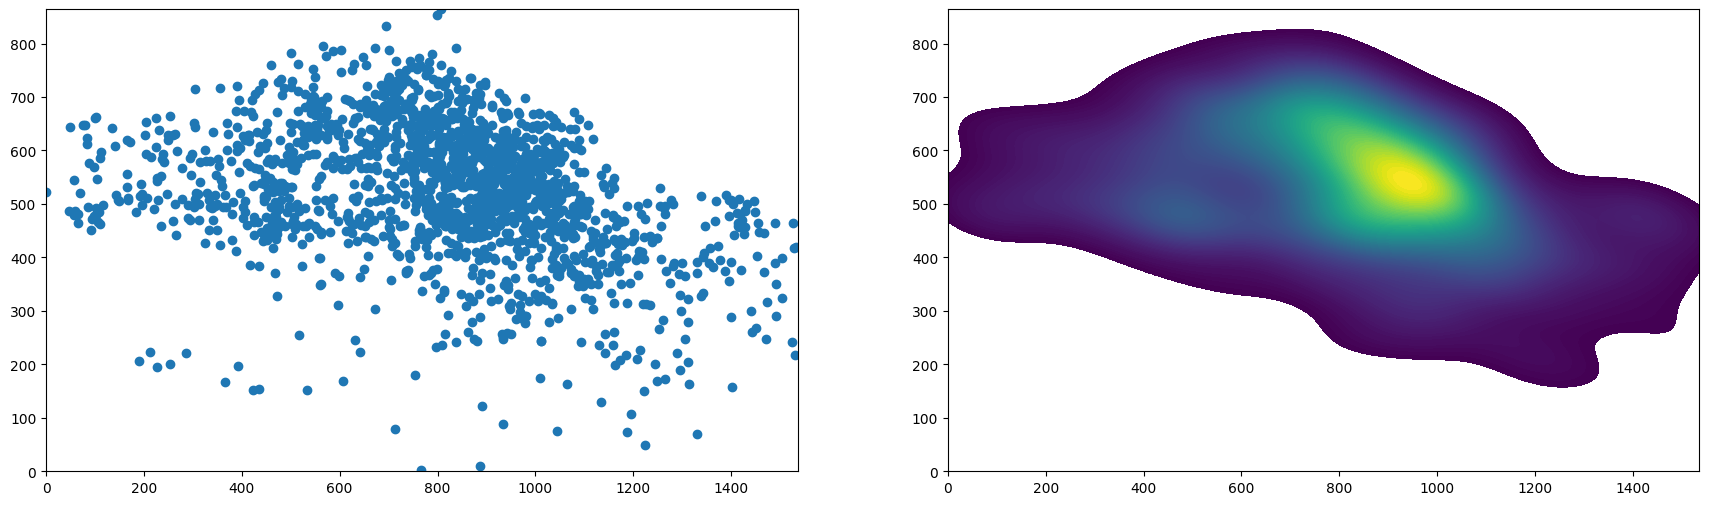

889
56766


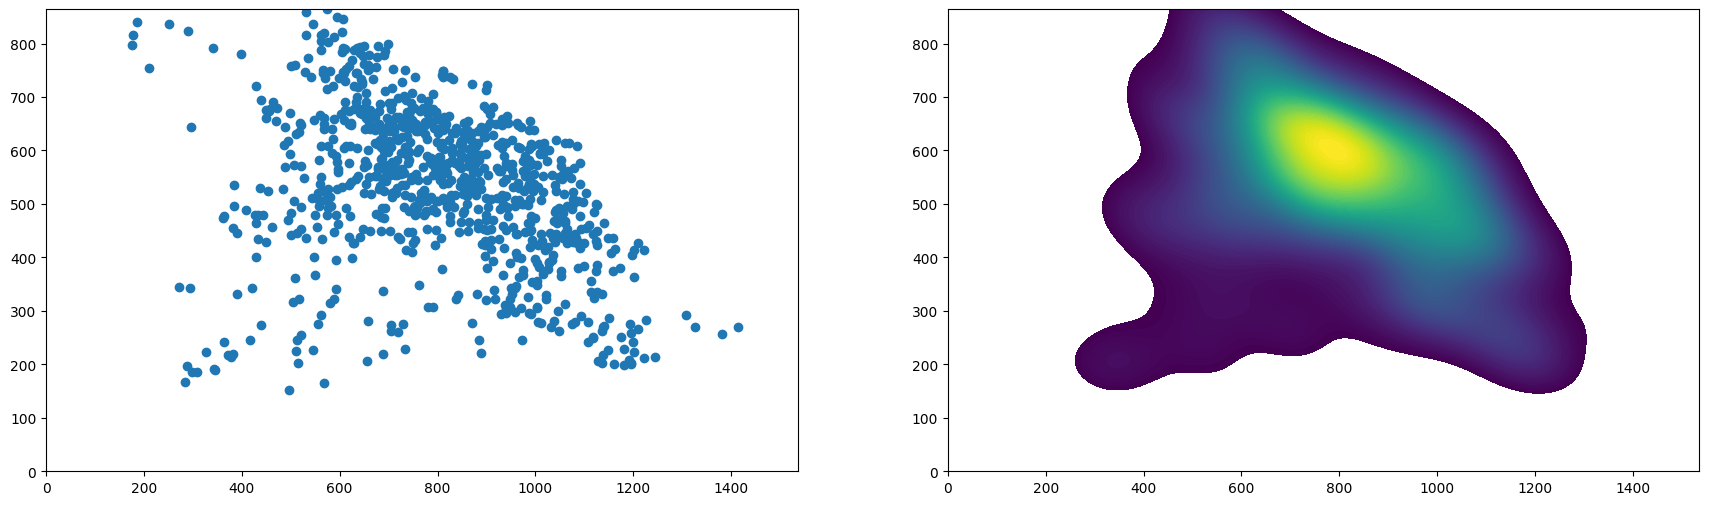

951
60471


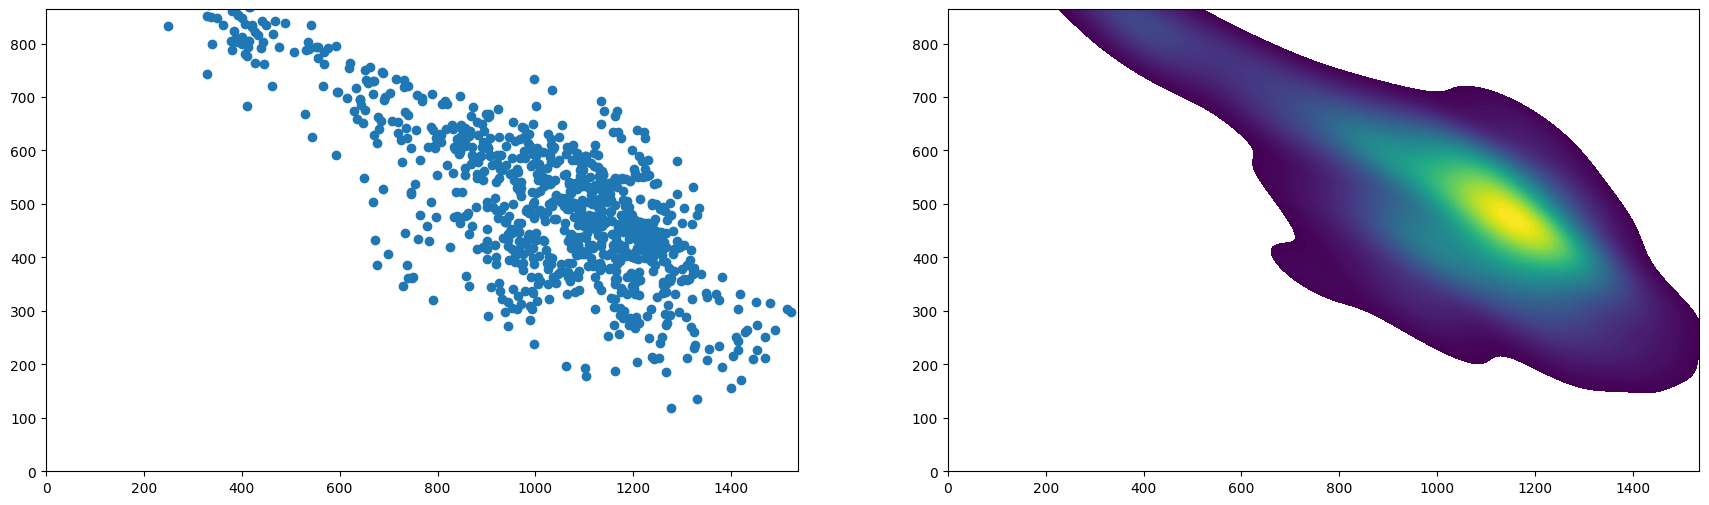

717
47574


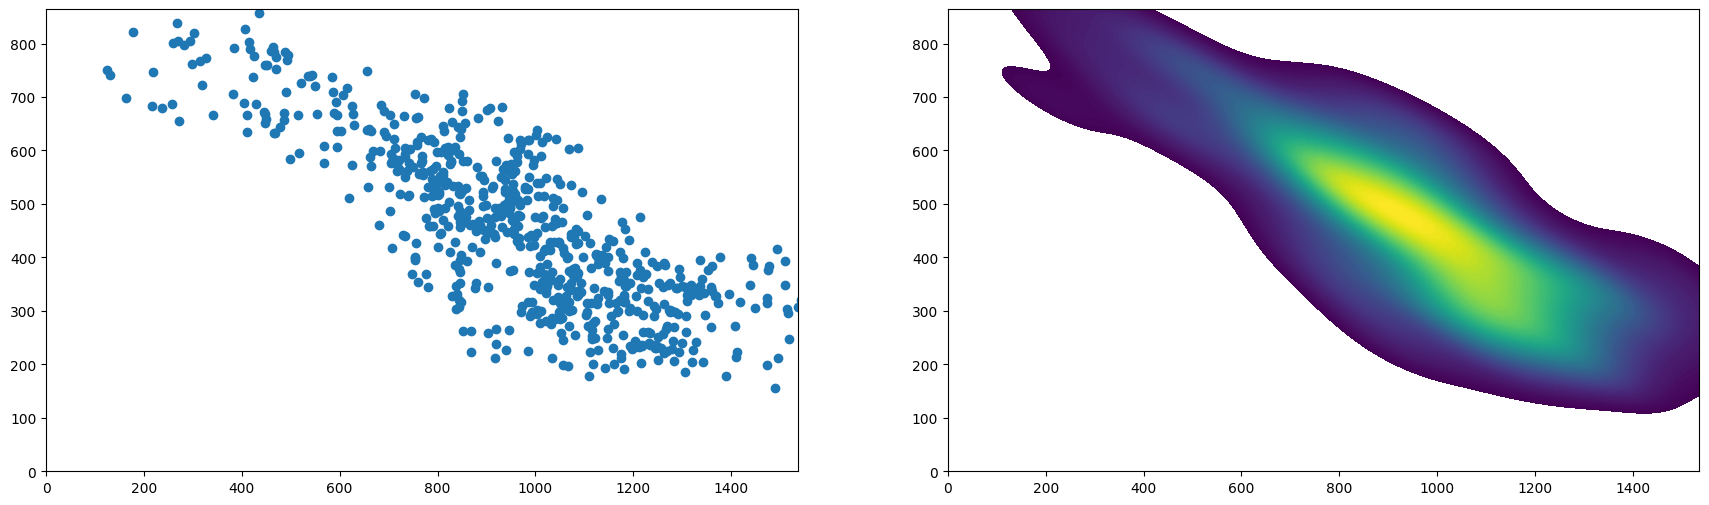

147
9821


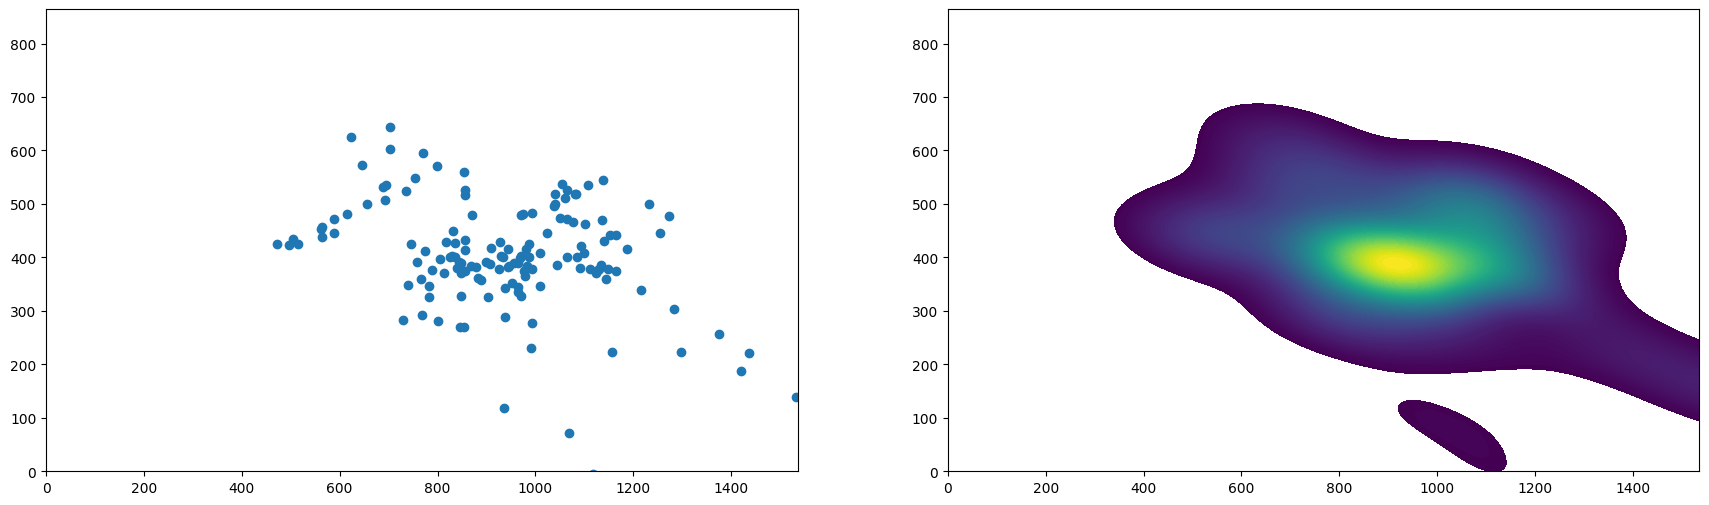

197
13023


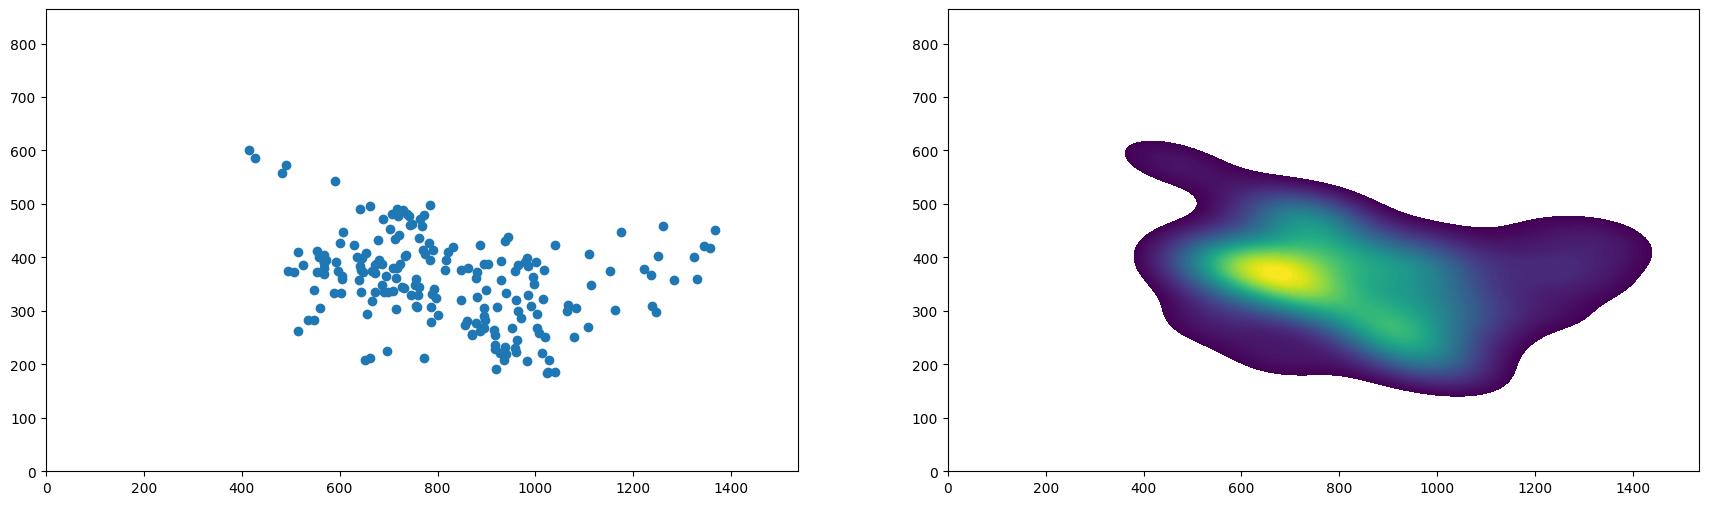

146
9826


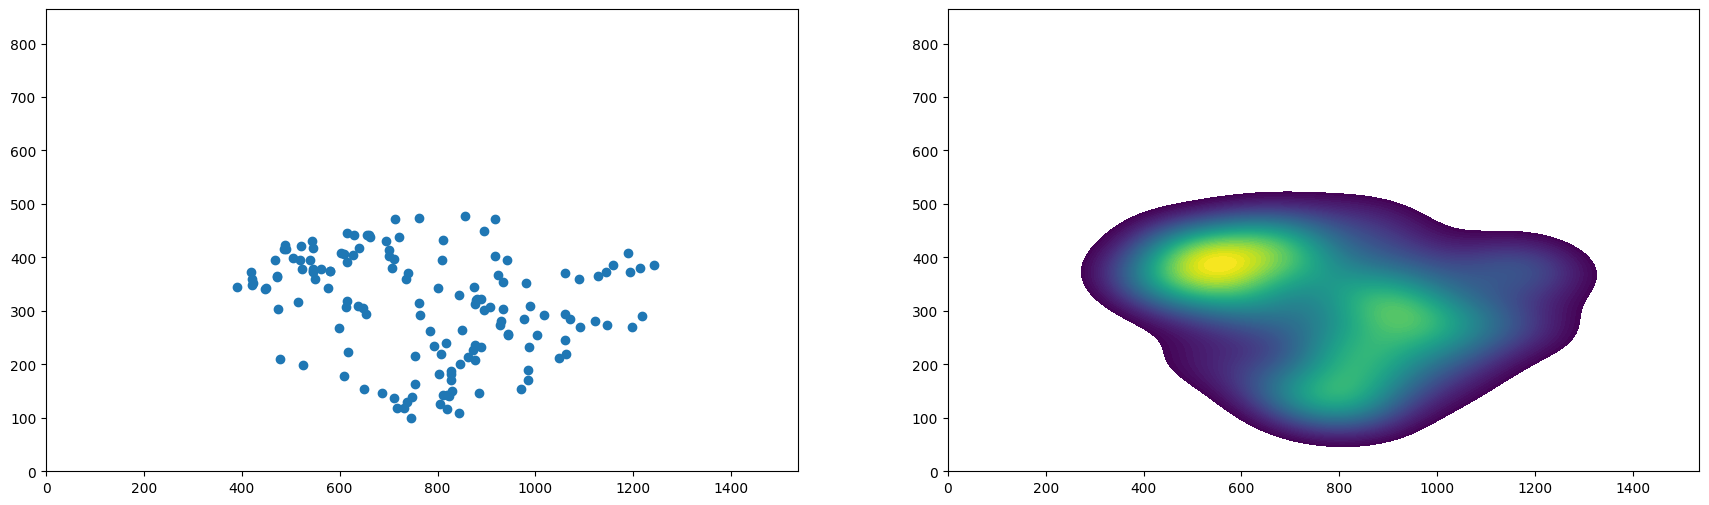

136
9085


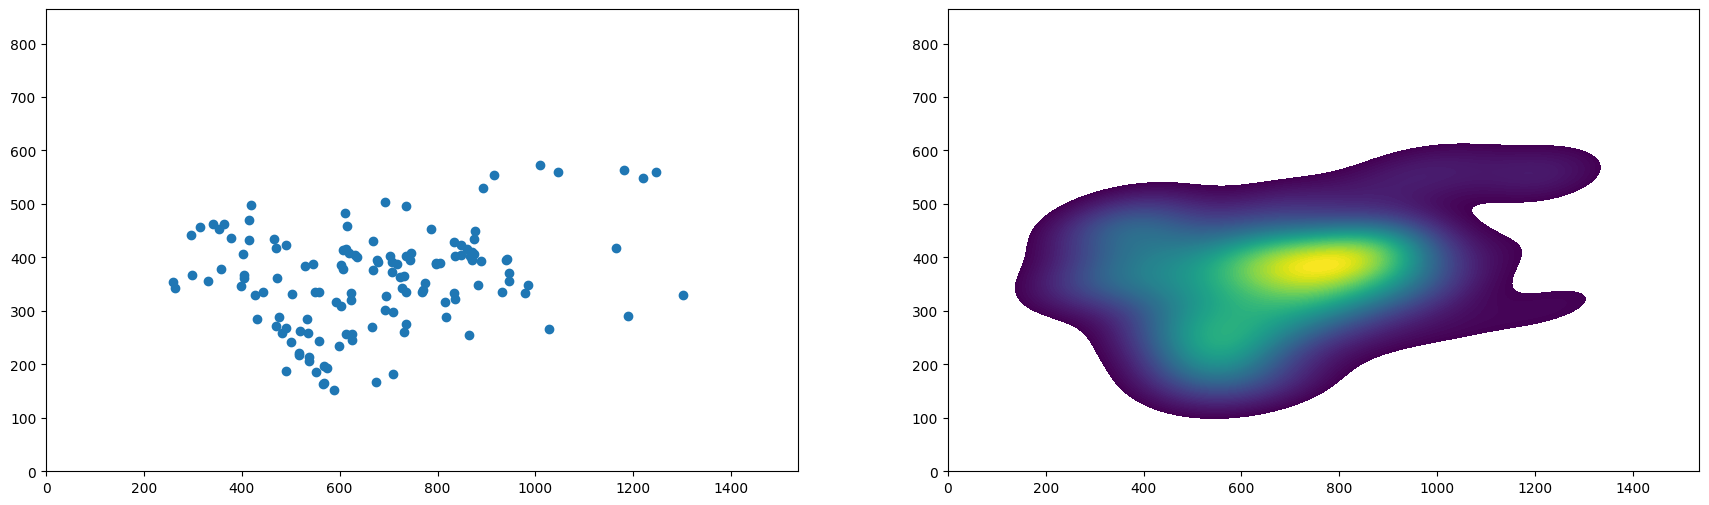

120
8027


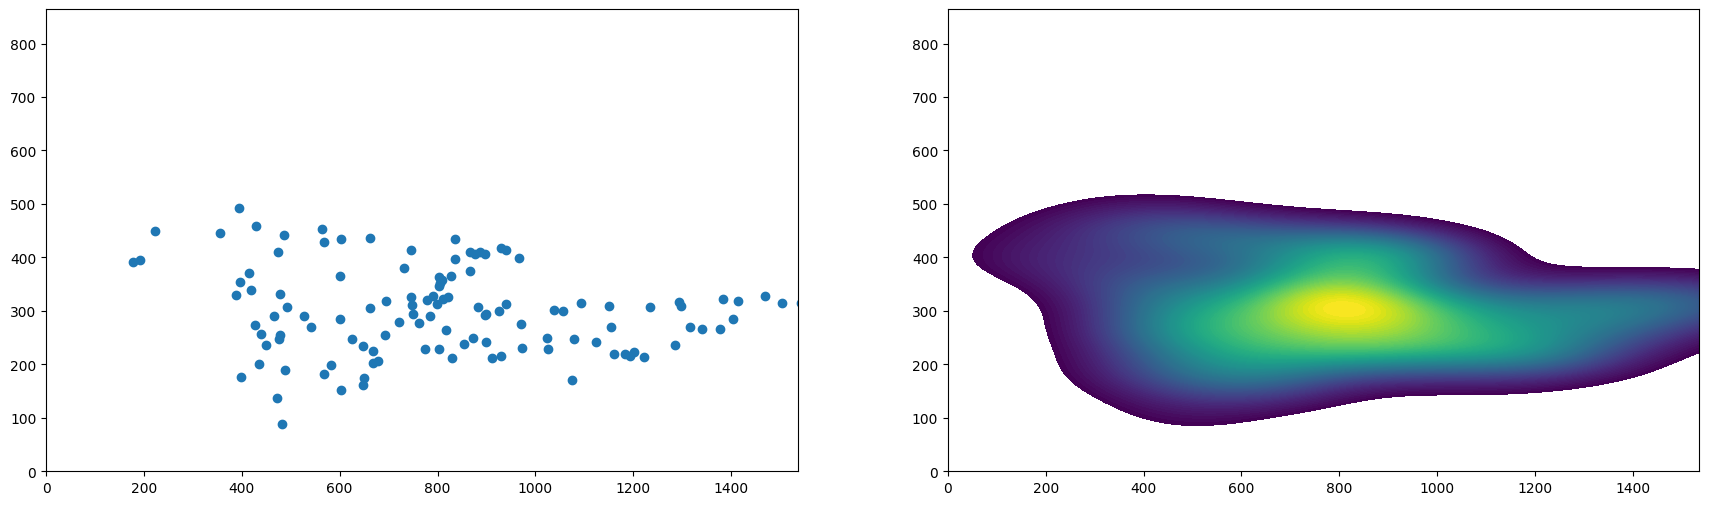

1387
91705


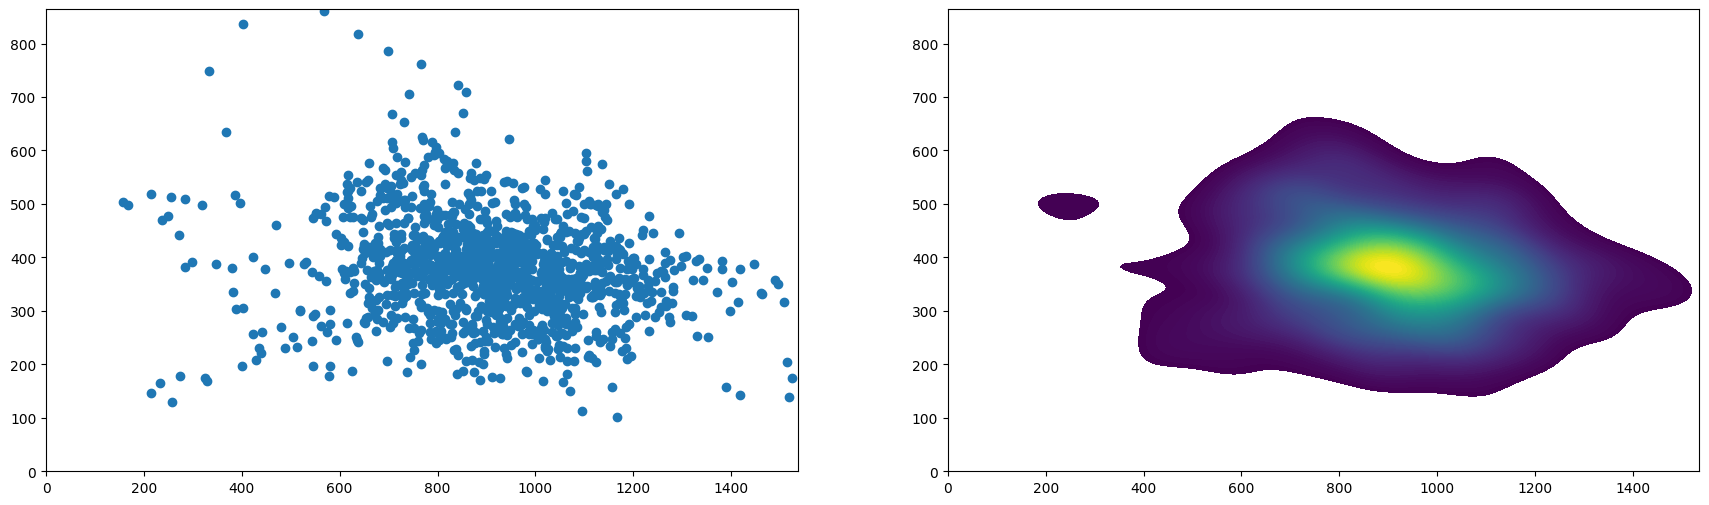

69
4770


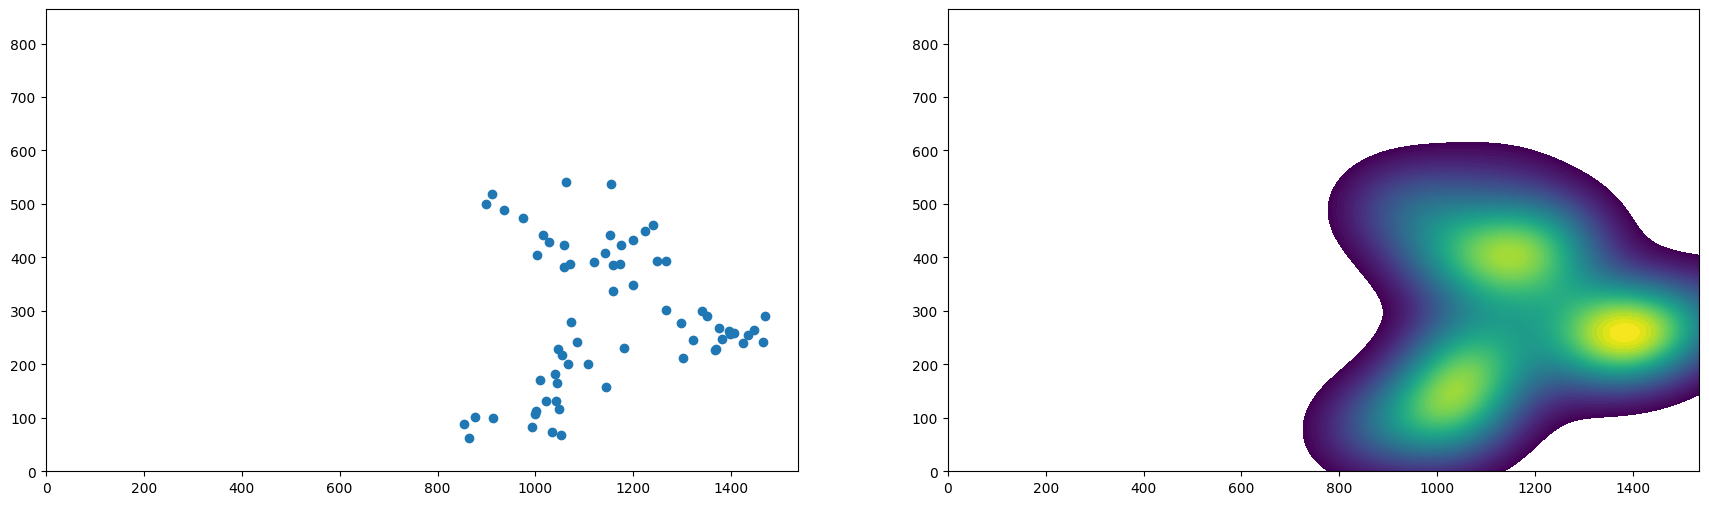

134
9032


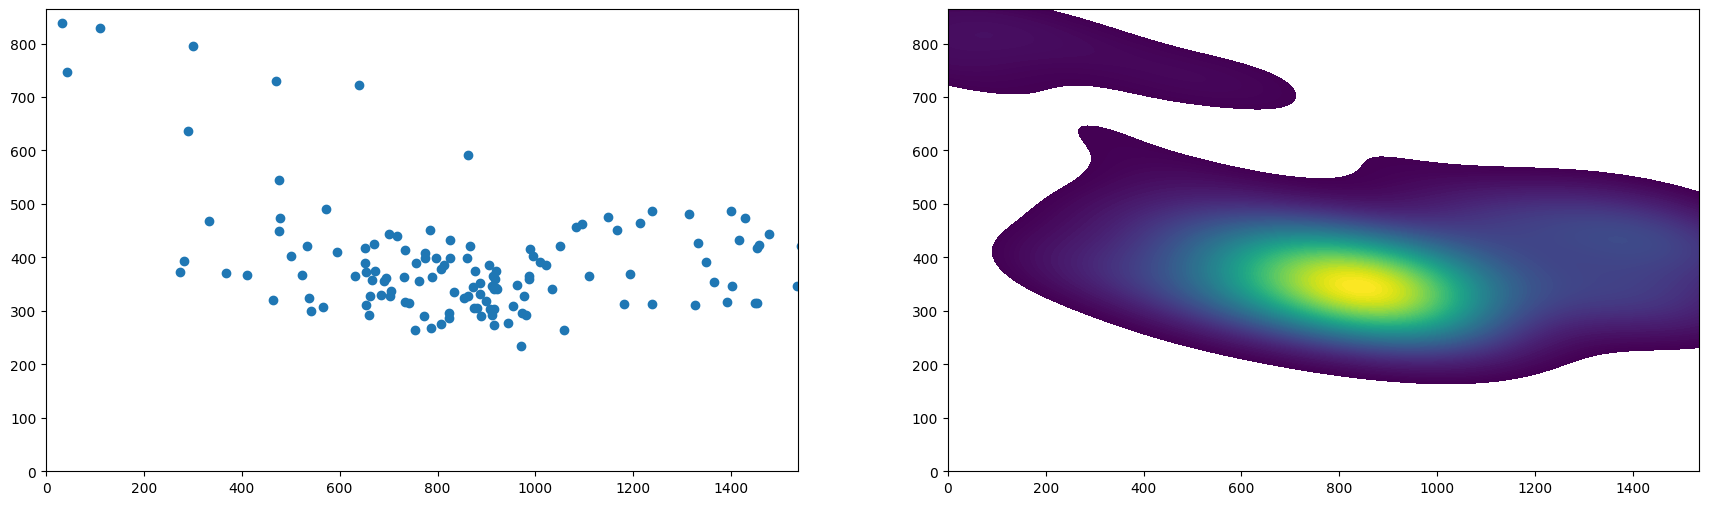

In [84]:
sample = df[df['workerid']=='Olha']
resolution = sample.iloc[0].deviceInfo['screen'].split('x')
resolution = (int(resolution[0]), int(resolution[1]))
for i in range(12):
    cur_sample = sample.iloc[i]
    gaze_sample = cur_sample.gaze
    x = np.array([g['x'] for g in gaze_sample.values()])
    y = np.array([g['y'] for g in gaze_sample.values()])
    print(len(x))
    print(cur_sample.answerTime)
    # make a scatterplot on the left and a heatmap on the right, keep proportions of the screen
    fig, axs = plt.subplots(1, 2, figsize=(2*(resolution[0]*6/resolution[1]), 6))
    axs[0].scatter(x, y)
    axs[0].set_xlim(0, resolution[0])
    axs[0].set_ylim(0, resolution[1])
    sns.kdeplot(x=x, y=y, ax=axs[1], fill=True, cmap='viridis', levels=100)
    axs[1].set_xlim(0, resolution[0])
    axs[1].set_ylim(0, resolution[1])



    plt.show()